# Capstone 2 on Airline Delays: Preprocessing
10/14/22

From our data wrangling and exploratory analysis, we've learned some interesting things about our data: what time of year flights are likely to get delayed/cancelled, which airlines are the worst offenders, etc. Recall that we're just looking at flights leaving RDU airport from Jul 2021-Jun 2022. Again, our data is from here: https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr.

Now let's get our data into shape so we can do some modeling with it.

In [1]:
#Import necessary packages and load dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_RDU = pd.read_csv('RDU_departures.csv')

In [2]:
df_RDU.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df_RDU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   QUARTER              52645 non-null  int64  
 1   MONTH                52645 non-null  int64  
 2   DAY_OF_MONTH         52645 non-null  int64  
 3   DAY_OF_WEEK          52645 non-null  object 
 4   FL_DATE              52645 non-null  object 
 5   CARRIER              52645 non-null  object 
 6   FL_NUM               52645 non-null  int64  
 7   ORIGIN               52645 non-null  object 
 8   ORIGIN_CITY          52645 non-null  object 
 9   ORIGIN_STATE         52645 non-null  object 
 10  DEST                 52645 non-null  object 
 11  DEST_CITY            52645 non-null  object 
 12  DEST_STATE           52645 non-null  object 
 13  CRS_DEP_TIME         52645 non-null  object 
 14  DEP_TIME             51170 non-null  object 
 15  DEP_DELAY            51175 non-null 

## Creating a Result column
Up to now, we've had two dependent variable results: flight delays >15 min and flight cancellations. We really need to commit to one result column! Let's create one categorical variable "RESULT" that captures both of these. 

What if we combine DEP_DELAY_GROUP with CANCELLED?

DEP_DELAY_GROUP              

                    -2=delay of <-15 min
                  -1=delay between -15 and -1 min
                     0=delay between 0 and 14 min
                    1=delay between 15 and 29 min
                    2=delay between 30 and 44 min
                all the way to 12=delay >=180 min

Let's make a new RESULT group like so:

                0 = no delay
                1 = delay of 1 hour or less
                2 = delay of 2 hours or less
                3 = delay of more than 2 hours
                4 = cancelled

In [4]:
df_RDU['RESULT']=0
df_RDU.loc[(df_RDU['DEP_DELAY_GROUP']>0) & (df_RDU['DEP_DELAY_GROUP']<4), 'RESULT']=1
df_RDU.loc[(df_RDU['DEP_DELAY_GROUP']>4) & (df_RDU['DEP_DELAY_GROUP']<12), 'RESULT']=2
df_RDU.loc[df_RDU['DEP_DELAY_GROUP']==12, 'RESULT']=3
df_RDU.loc[df_RDU['CANCELLED']=='Cancelled', 'RESULT']=4

In [5]:
df_RDU['RESULT'].value_counts()

0    42936
1     5542
2     1898
4     1500
3      769
Name: RESULT, dtype: int64

Now we have a column 'RESULT' which tells us how delayed a flight was (-2 through 12) or if it was cancelled (13).

## Getting rid of duplicate variables

I was hesitant to get rid of variables before. But we need to delete certain duplicate ones so we don't have problems with collinearity/redundant data.

Let's look at what data we have and what types.

In [6]:
df_RDU.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK             object
FL_DATE                 object
CARRIER                 object
FL_NUM                   int64
ORIGIN                  object
ORIGIN_CITY             object
ORIGIN_STATE            object
DEST                    object
DEST_CITY               object
DEST_STATE              object
CRS_DEP_TIME            object
DEP_TIME                object
DEP_DELAY              float64
DEP_DEL15               object
DEP_DELAY_GROUP        float64
CRS_ARR_TIME            object
ARR_TIME                object
ARR_DELAY              float64
ARR_DEL15               object
ARR_DELAY_GROUP        float64
CANCELLED               object
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIR

First let's fix some dtypes.

In [7]:
df_RDU['QUARTER'] = df_RDU['QUARTER'].astype('category')
df_RDU['MONTH'] = df_RDU['MONTH'].astype('category')
df_RDU['DAY_OF_MONTH'] = df_RDU['DAY_OF_MONTH'].astype('category')
df_RDU['DAY_OF_WEEK'] = df_RDU['DAY_OF_WEEK'].astype('category')
df_RDU['FL_DATE'] = df_RDU['FL_DATE'].astype('datetime64') # not sure if this one works
df_RDU['FL_NUM'] = df_RDU['FL_NUM'].astype('object')
# df_RDU['CRS_DEP_TIME'] = pd.to_datetime(df_RDU['CRS_DEP_TIME'], format='%H:%M', errors='coerce').dt.time
# df_RDU['DEP_TIME'] = pd.to_datetime(df_RDU['DEP_TIME'], format='%H%M', errors='coerce').dt.time
df_RDU['RESULT'] = df_RDU['RESULT'].astype('category')

We don't need FL_DATE since we have MONTH and DAY_OF_MONTH.

We don't need 'ORIGIN', 'ORIGIN_CITY', and 'ORIGIN_STATE': we have subsetted our data so that we're only working with RDU.

We only need 'DEST' (destination airport code), 'DEST_CITY', and 'DEST_STATE' are redundant.

We have 'RESULT' so we don't need 'DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', and 'CANCELLED' anymore.

DEP_TIME is very close to CRS_DEP_TIME; ARR_TIME and CRS_DEP_TIME are very close; and ACTUAL_ELAPSED_TIME, AIR_TIME, and CRS_ELAPSED_TIME are also very close. Let's drop the actual times and keep the scheduled times.

In [8]:
df_RDU2 = df_RDU.drop(columns=['FL_DATE', 'ORIGIN', 'ORIGIN_CITY', 'ORIGIN_STATE', 'DEST_CITY', 'DEST_STATE',
                              'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
                               'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 
                               'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'CANCELLED'])
df_RDU2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   QUARTER              52645 non-null  category
 1   MONTH                52645 non-null  category
 2   DAY_OF_MONTH         52645 non-null  category
 3   DAY_OF_WEEK          52645 non-null  category
 4   CARRIER              52645 non-null  object  
 5   FL_NUM               52645 non-null  object  
 6   DEST                 52645 non-null  object  
 7   CRS_DEP_TIME         52645 non-null  object  
 8   CRS_ARR_TIME         52626 non-null  object  
 9   CRS_ELAPSED_TIME     52645 non-null  float64 
 10  DISTANCE             52645 non-null  float64 
 11  CARRIER_DELAY        8988 non-null   float64 
 12  WEATHER_DELAY        8988 non-null   float64 
 13  NAS_DELAY            8988 non-null   float64 
 14  SECURITY_DELAY       8988 non-null   float64 
 15  LATE_AIRCRAFT_DELAY

Let's do some "binning" for CRS_DEP_TIME and CRS_ARR_TIME.

        Morning: 3:01am to 9am (030100 to 090000)
        Midday: 9:01am to 3pm (090100 to 150000)
        Afternoon_Evening: 3:01pm to 9pm (150100 to 210000)
        Late_Night: 9:01pm to 3am (210100 to 030000)

In [9]:
# first we have to do some cleanup

df_RDU2['CRS_DEP_TIME'] = df_RDU2['CRS_DEP_TIME'].str.replace(':','')
df_RDU2['CRS_DEP_TIME'] = pd.to_numeric(df_RDU2['CRS_DEP_TIME'])
df_RDU2['CRS_ARR_TIME'] = df_RDU2['CRS_ARR_TIME'].str.replace(':','')
df_RDU2['CRS_ARR_TIME'] = pd.to_numeric(df_RDU2['CRS_ARR_TIME'])

In [10]:
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 240000, 'DEP_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 210000, 'DEP_TIME_BINS'] = 'AFTERNOON_EVENING'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 150000, 'DEP_TIME_BINS'] = 'MIDDAY'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 90000, 'DEP_TIME_BINS'] = 'MORNING'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 30000, 'DEP_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2['DEP_TIME_BINS'].value_counts()

AFTERNOON_EVENING    17958
MIDDAY               17373
MORNING              16909
LATE_NIGHT             405
Name: DEP_TIME_BINS, dtype: int64

In [11]:
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 240000, 'ARR_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 210000, 'ARR_TIME_BINS'] = 'AFTERNOON_EVENING'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 150000, 'ARR_TIME_BINS'] = 'MIDDAY'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 90000, 'ARR_TIME_BINS'] = 'MORNING'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 30000, 'ARR_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2['ARR_TIME_BINS'].value_counts()

MIDDAY               19011
AFTERNOON_EVENING    18907
MORNING               9984
LATE_NIGHT            4724
Name: ARR_TIME_BINS, dtype: int64

In [12]:
df_RDU2 = df_RDU2.drop(columns=['CRS_DEP_TIME', 'CRS_ARR_TIME'])

Finally for the different kinds of delay,

    'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', and 'LATE_AIRCRAFT_DELAY',

we don't need this down to the minute. 

Let's binarize these values: 0 for delay and 1 for no delay caused by this factor.

(First we have to fill in NaN values; we will assume NaN means 0, there was no delay caused by this factor.)

In [13]:
df_RDU2['CARRIER_DELAY'] = df_RDU2['CARRIER_DELAY'].fillna(value=0)
df_RDU2['WEATHER_DELAY'] = df_RDU2['WEATHER_DELAY'].fillna(value=0)
df_RDU2['NAS_DELAY'] = df_RDU2['NAS_DELAY'].fillna(value=0)
df_RDU2['SECURITY_DELAY'] = df_RDU2['SECURITY_DELAY'].fillna(value=0)
df_RDU2['LATE_AIRCRAFT_DELAY'] = df_RDU2['LATE_AIRCRAFT_DELAY'].fillna(value=0)

In [14]:
df_RDU2.loc[df_RDU2['CARRIER_DELAY']>0, 'CARRIER_DELAY'] = 1
df_RDU2.loc[df_RDU2['WEATHER_DELAY']>0, 'WEATHER_DELAY'] = 1
df_RDU2.loc[df_RDU2['NAS_DELAY']>0, 'NAS_DELAY'] = 1
df_RDU2.loc[df_RDU2['SECURITY_DELAY']>0, 'SECURITY_DELAY'] = 1
df_RDU2.loc[df_RDU2['LATE_AIRCRAFT_DELAY']>0, 'LATE_AIRCRAFT_DELAY'] = 1

In [15]:
df_RDU2['CARRIER_DELAY'] = df_RDU2['CARRIER_DELAY'].astype('category')
df_RDU2['WEATHER_DELAY'] = df_RDU2['WEATHER_DELAY'].astype('category')
df_RDU2['NAS_DELAY'] = df_RDU2['NAS_DELAY'].astype('category')
df_RDU2['SECURITY_DELAY'] = df_RDU2['SECURITY_DELAY'].astype('category')
df_RDU2['LATE_AIRCRAFT_DELAY'] = df_RDU2['LATE_AIRCRAFT_DELAY'].astype('category')

## Divide into X and y

In [16]:
X = df_RDU2.drop(columns='RESULT')
y = df_RDU2['RESULT']

## Dummy variables

Next we'll create dummy variables for our categorical variables.

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   QUARTER              52645 non-null  category
 1   MONTH                52645 non-null  category
 2   DAY_OF_MONTH         52645 non-null  category
 3   DAY_OF_WEEK          52645 non-null  category
 4   CARRIER              52645 non-null  object  
 5   FL_NUM               52645 non-null  object  
 6   DEST                 52645 non-null  object  
 7   CRS_ELAPSED_TIME     52645 non-null  float64 
 8   DISTANCE             52645 non-null  float64 
 9   CARRIER_DELAY        52645 non-null  category
 10  WEATHER_DELAY        52645 non-null  category
 11  NAS_DELAY            52645 non-null  category
 12  SECURITY_DELAY       52645 non-null  category
 13  LATE_AIRCRAFT_DELAY  52645 non-null  category
 14  DEP_TIME_BINS        52645 non-null  object  
 15  ARR_TIME_BINS      

Now we can actually create dummy variables.

In [18]:
X = pd.get_dummies(X, columns=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CARRIER', 'DEST',
                               'DEP_TIME_BINS', 'ARR_TIME_BINS', 'CARRIER_DELAY', 
                               'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'], drop_first=True)
X.head()

,FL_NUM,CRS_ELAPSED_TIME,DISTANCE,QUARTER_2,QUARTER_3,QUARTER_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DEP_TIME_BINS_MIDDAY,DEP_TIME_BINS_MORNING,ARR_TIME_BINS_LATE_NIGHT,ARR_TIME_BINS_MIDDAY,ARR_TIME_BINS_MORNING,CARRIER_DELAY_1.0,WEATHER_DELAY_1.0,NAS_DELAY_1.0,SECURITY_DELAY_1.0,LATE_AIRCRAFT_DELAY_1.0
0,3242,150.0,646.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3242,150.0,646.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3242,150.0,646.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3242,150.0,646.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3242,150.0,646.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
X.columns

Index(['FL_NUM', 'CRS_ELAPSED_TIME', 'DISTANCE', 'QUARTER_2', 'QUARTER_3',
       'QUARTER_4', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5',
       ...
       'DEP_TIME_BINS_MIDDAY', 'DEP_TIME_BINS_MORNING',
       'ARR_TIME_BINS_LATE_NIGHT', 'ARR_TIME_BINS_MIDDAY',
       'ARR_TIME_BINS_MORNING', 'CARRIER_DELAY_1.0', 'WEATHER_DELAY_1.0',
       'NAS_DELAY_1.0', 'SECURITY_DELAY_1.0', 'LATE_AIRCRAFT_DELAY_1.0'],
      dtype='object', length=129)

## Train/test sets

Now it's time to divide our data into train and test sets.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale/standardize numeric features

We have two remaining numeric features that need to be scaled/standardized:

    'CRS_ELAPSED_TIME', 'DISTANCE'

To figure out which scaler we should use, let's make a couple quick visualizations.

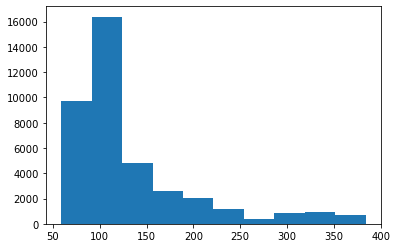

In [21]:
plt.hist(X_train['CRS_ELAPSED_TIME'])
plt.show()

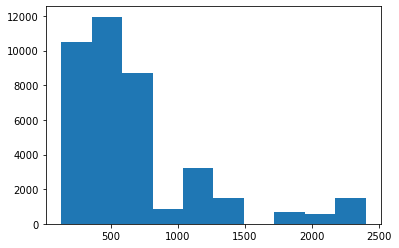

In [22]:
plt.hist(X_train['DISTANCE'])
plt.show()

Since all these have long tails, it makes sense to use a log transformer rather than a standard scaler. We will fit and transform on X_train, and we will transform on X_test.

In [23]:
from sklearn.preprocessing import PowerTransformer
pow_trans0 = PowerTransformer()
X_train['CRS_ELAPSED_TIME_LG'] = pow_trans0.fit_transform(X_train[['CRS_ELAPSED_TIME']])
X_test['CRS_ELAPSED_TIME_LG'] = pow_trans0.transform(X_test[['CRS_ELAPSED_TIME']])

pow_trans1 = PowerTransformer()
X_train['DISTANCE_LG'] = pow_trans1.fit_transform(X_train[['DISTANCE']])
X_test['DISTANCE_LG'] = pow_trans1.transform(X_test[['DISTANCE']])

<ipython-input-23-1f4793e60826>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['CRS_ELAPSED_TIME_LG'] = pow_trans0.fit_transform(X_train[['CRS_ELAPSED_TIME']])
<ipython-input-23-1f4793e60826>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['CRS_ELAPSED_TIME_LG'] = pow_trans0.transform(X_test[['CRS_ELAPSED_TIME']])
<ipython-input-23-1f4793e60826>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Despite all the error messages this seems to have worked okay.

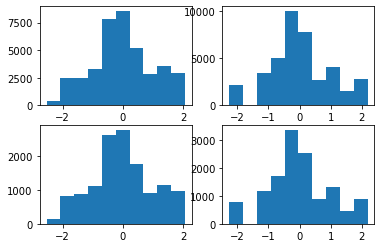

In [24]:
fig, ax = plt. subplots(2, 2)
ax[0, 0].hist(X_train['CRS_ELAPSED_TIME_LG'])
ax[0, 1].hist(X_train['DISTANCE_LG'])
ax[1, 0].hist(X_test['CRS_ELAPSED_TIME_LG'])
ax[1, 1].hist(X_test['DISTANCE_LG'])
plt.show()

Looks better!

In [27]:
X_train.drop(columns=['CRS_ELAPSED_TIME', 'DISTANCE'], inplace=True)
X_test.drop(columns=['CRS_ELAPSED_TIME', 'DISTANCE'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')